In [1]:
# === project setup ===
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parents[0]
print("PROJECT_ROOT =", PROJECT_ROOT)

if not (PROJECT_ROOT / "src").exists():
    raise RuntimeError("src directory not found — wrong PROJECT_ROOT")

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

PROJECT_ROOT = R:\analysis_tools\analysis_tools


In [2]:
# === imports ===
from h5py import File 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import copy
import importlib
import pandas as pd
import h5py

In [3]:
from src.utils.parse_h5df import * 
from src.utils.fb_quasi_parse_events import reparse_trigger_v1_1, trigger_to_event_v1_1
from src.utils.events import * 
from src.utils.spectral_analysis import *
from src.utils.transformations import unit_to_db
from src.utils.montage_processing import *
from src.utils.rereferencing import *

In [35]:
from src.utils.CSP import calculate_CSP

In [37]:
from src.visualization.plot_signal import plot_signal
from src.visualization.plot_csp_components import plot_CSP_components

In [5]:
DATA_FOLDER = r"..\data"
RECORD = "OM-point_full_typed.h5"

In [39]:
EEG_CHANNELS = np.arange(64)
CED_FILE = r"../resources/mks64_standard.ced"

ch_labels = get_channel_names(CED_FILE)
positions = get_topo_positions(CED_FILE)

labels_ROA = ["FC5", "FC3", "FC1", "C1", "CP1", "CP3", "CP5", "C5", "C3"] # mu rhythm
idxs_ROA = [find_ch_idx(ch, CED_FILE) for ch in labels_ROA]

Fs = 1000 # Hz
s_to_idx = lambda x: int(x * Fs)
ms_to_idx = lambda x: int(x // 1000 * Fs)

In [40]:
from matplotlib import colormaps as cm
from matplotlib.colors import ListedColormap
viridisBig = cm.get_cmap('jet')
newcmp = ListedColormap(viridisBig(np.linspace(0, 1, 15)))

In [7]:
# === data ===
path = os.path.join(DATA_FOLDER, RECORD)
with h5py.File(path, "r") as h5f:
    data = h5f["eeg/data"][:]
data.shape

(399720, 65)

In [8]:
# bandpass filter
raw_eeg = data[:, EEG_CHANNELS] * 1E6 # uV
filt_eeg = bandpass_filter(raw_eeg, fs=Fs, low=0.5, high=40)

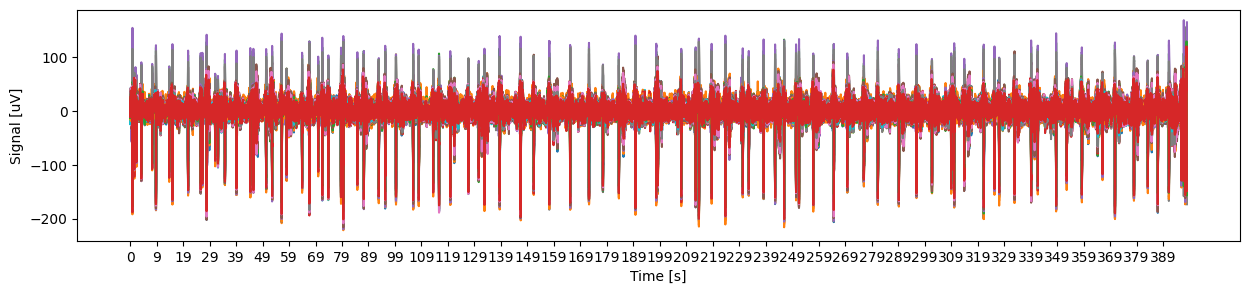

In [9]:
start_s, end_s = 0, raw_eeg.shape[0] // Fs 
plot_signal(start_s, end_s, filt_eeg, s_to_idx, plot=True)  # plot all channels

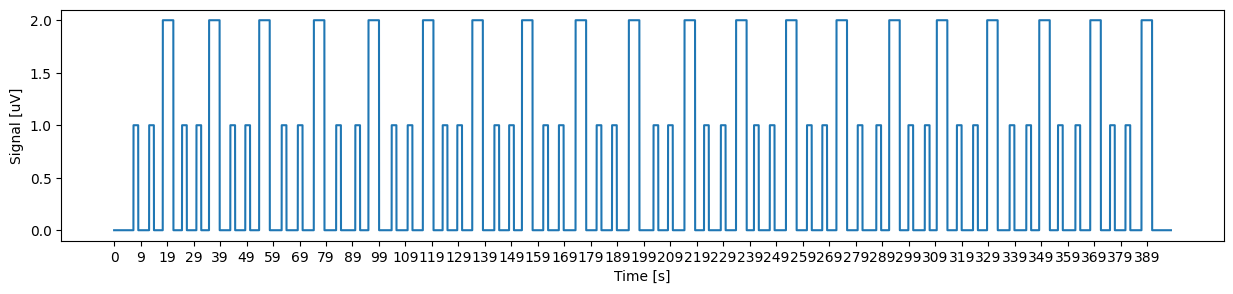

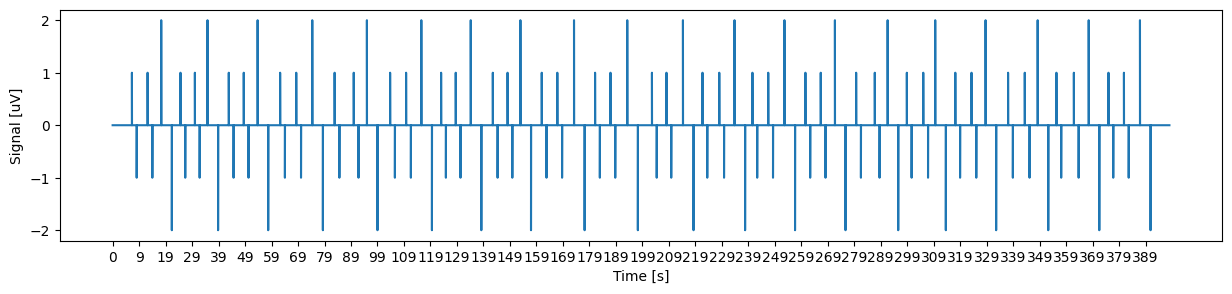

In [10]:
trigger = data[:, -1]
plot_signal(start_s, end_s, data[:, -1], s_to_idx, plot=False)  # plot all channels
plot_signal(start_s, end_s, np.diff(trigger), s_to_idx, plot=True)

In [18]:
trigger_diff = np.diff(trigger)
mask_motor_start = np.where(trigger_diff == 1)[0].tolist()
mask_motor_finish = np.where(trigger_diff == -1)[0].tolist()
mask_rest_start = np.where(trigger_diff == 2)[0].tolist()
mask_rest_finish = np.where(trigger_diff == -2)[0].tolist()

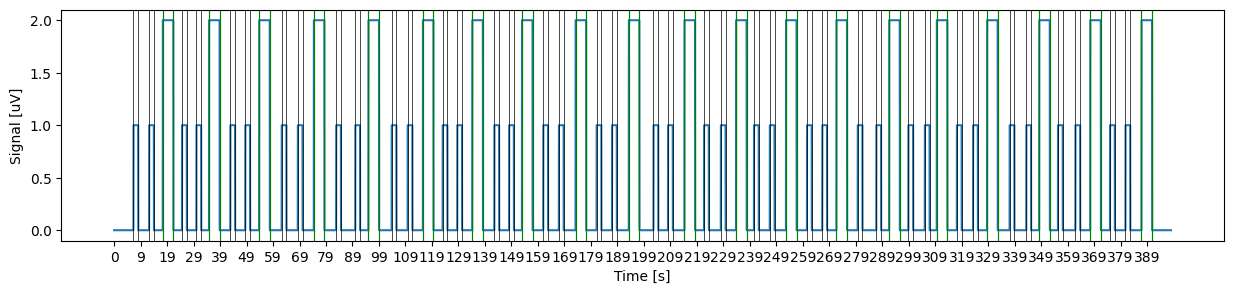

In [22]:
plot_signal(start_s, end_s, trigger, s_to_idx, plot=False)
for epoch_start in mask_motor_start + mask_motor_finish:
    plt.axvline(epoch_start, color="black", linewidth=0.5)
for epoch_start in mask_rest_start + mask_rest_finish:
    plt.axvline(epoch_start, color="green", linewidth=0.85)

In [27]:
def cut_epoch(mask_start, mask_finish, data):
    epochs = []
    for start, end in zip(mask_start, mask_finish):
        epochs.append(data[start:end])
    return np.array(epochs)

epochs_motor = cut_epoch(mask_motor_start, mask_motor_finish, filt_eeg)
epochs_rest = cut_epoch(mask_rest_start, mask_rest_finish, filt_eeg)

In [30]:
epochs_motor.shape, epochs_rest.shape

((40, 1800, 64), (20, 4000, 64))

In [34]:
data_motor = epochs_motor.reshape(-1, epochs_motor.shape[2])
data_rest = epochs_rest.reshape(-1, epochs_rest.shape[2])
data_motor.shape, data_rest.shape

((72000, 64), (80000, 64))

In [38]:
# === CSP === 
from scipy.linalg import eigh
from mne.viz import plot_topomap
import matplotlib.gridspec as gridspec

In [45]:
# Anatoly Method
def cov_epoch(X):
    """
    X: (channels, time)
    """
    C = X @ X.T
    return C / np.trace(C)

def regularize(C, alpha=0.05):
    return (1 - alpha) * C + alpha * np.eye(C.shape[0])


# def calculate_CSP_AV(data_motor, data_rest):
#     covs_motor = np.array(data_motor)
#     covs_motor = np.array([cov_epoch(ep.T) for ep in epochs_motor])  # ep: (time, ch)
#     C_motor  = covs_motor.mean(axis=0)
#     C_motor  = regularize(C_motor,  alpha=0.05)

#     covs_rest = np.array([cov_epoch(ep.T) for ep in epochs_rest])  # ep: (time, ch)
#     C_rest  = covs_rest.mean(axis=0)
#     C_rest = regularize(C_rest, alpha=0.05)

In [49]:
covs_motor = cov_epoch(data_motor)

MemoryError: Unable to allocate 38.6 GiB for an array with shape (72000, 72000) and data type float64

In [48]:
covs_motor.shape

(72000, 64)

In [36]:
eigvals, eigvecs, A = calculate_CSP(epochs_motor, epochs_rest)

8-30 Hz -- done.
8-12 Hz -- done.
9-13 Hz -- done.
10-14 Hz -- done.
11-15 Hz -- done.


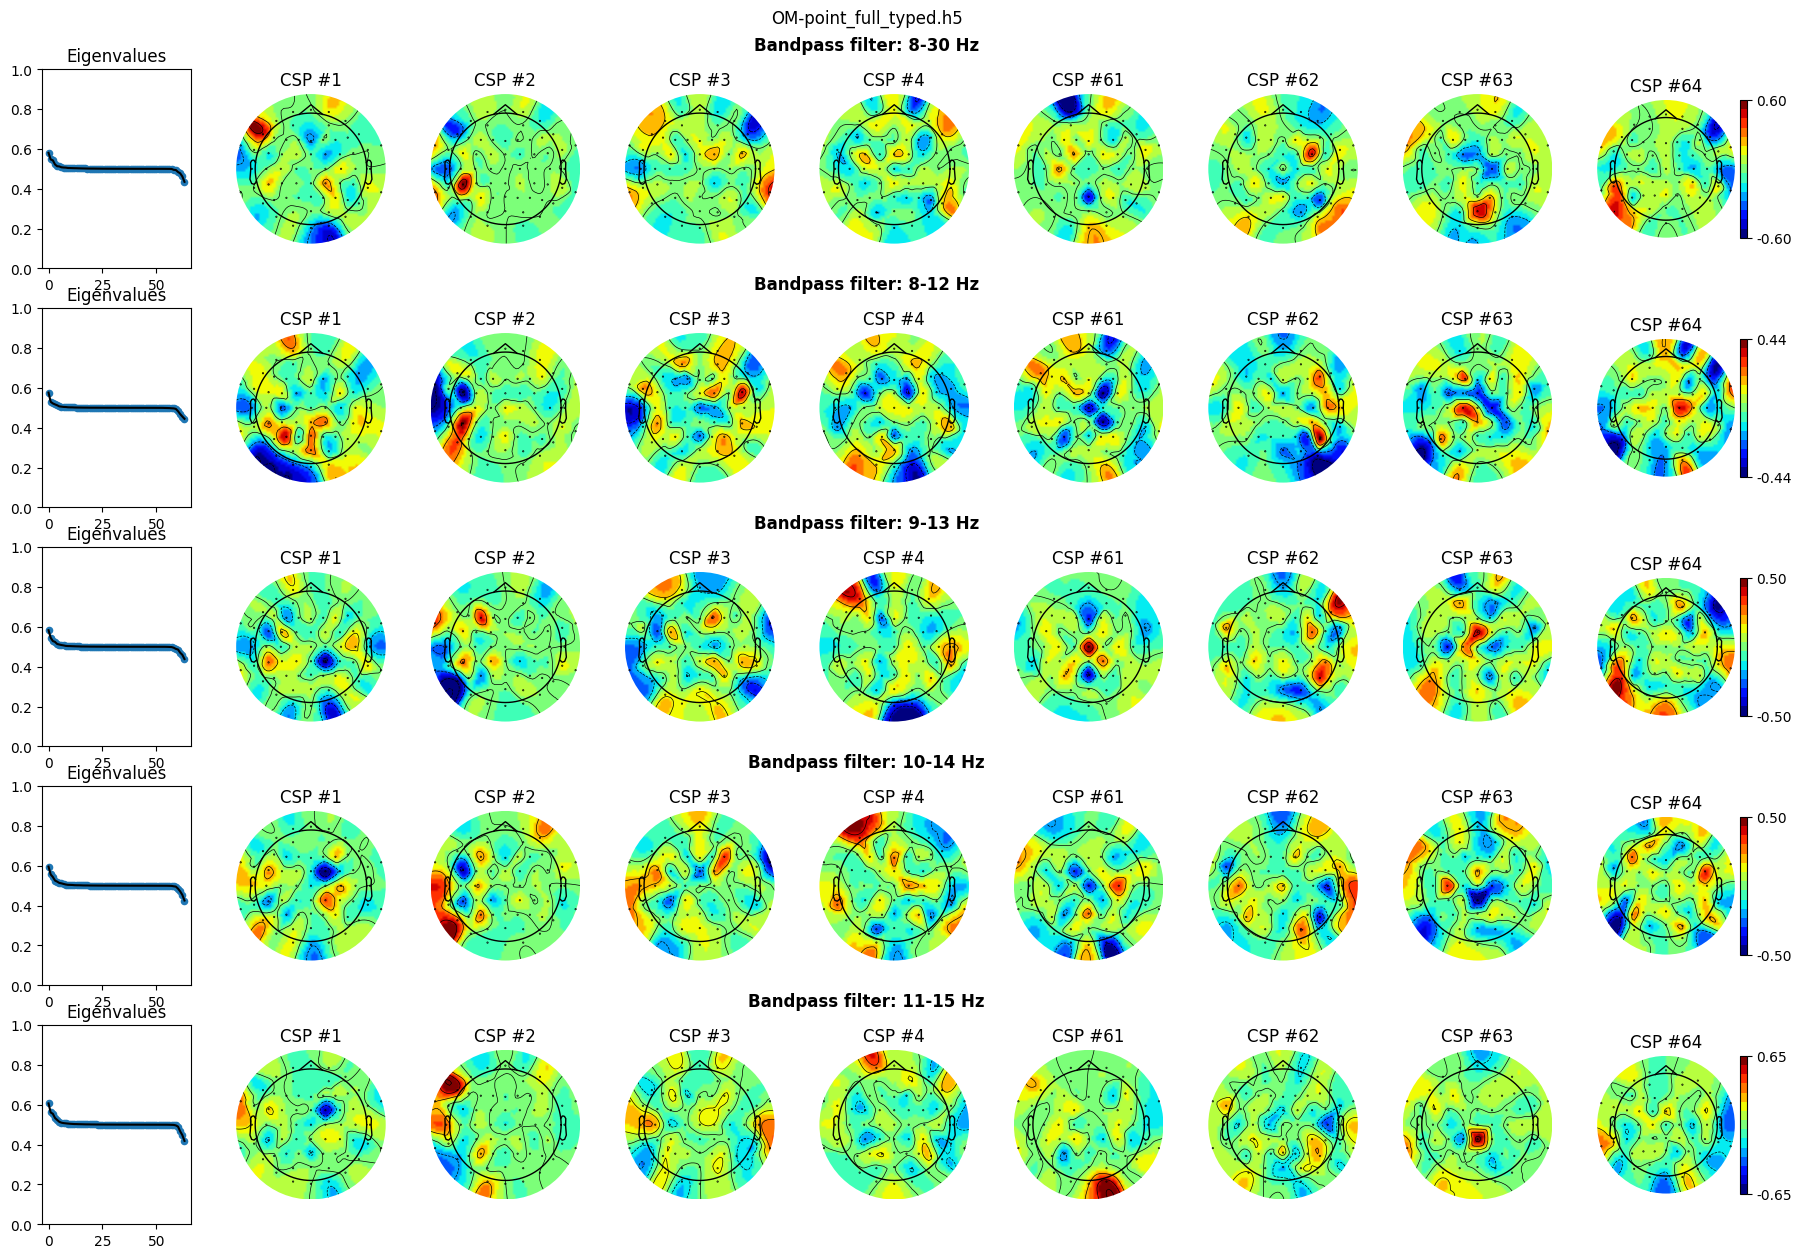

In [43]:
bands = [[8, 30], [8, 12], [9, 13], [10, 14], [11, 15]]

fig = plt.figure(figsize=(22, 3 * len(bands)))
gs = gridspec.GridSpec(len(bands), 9, height_ratios=[1]*len(bands), wspace=0.3)

for row_idx, (low_f, high_f) in enumerate(bands):
    filt_eeg = bandpass_filter(raw_eeg, fs=Fs, low=low_f, high=high_f)
    epochs_motor = cut_epoch(mask_motor_start, mask_motor_finish, filt_eeg)
    epochs_rest = cut_epoch(mask_rest_start, mask_rest_finish, filt_eeg)
    
    eigvals, eigvecs, A = calculate_CSP(epochs_motor, epochs_rest)
    
    plot_CSP_components(eigvals, A, positions, ch_labels, row_idx, gs, fig)

    # Добавляем название полосы **над всей строкой**
    ax0 = plt.subplot(gs[row_idx, 0])
    pos = ax0.get_position()  # BBox

    # Добавляем название полосы
    fig.text(0.5, pos.y1 + 0.01, f"Bandpass filter: {low_f}-{high_f} Hz",
             ha='center', va='bottom', fontsize=12, fontweight='bold')
    

    print(f"{low_f}-{high_f} Hz -- done.")
plt.suptitle(RECORD, y=0.92)
plt.show()